In [23]:
import numpy as np
import os
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.special import sph_harm
from scipy.signal import hilbert
from scipy.io import wavfile
from scipy.spatial import ConvexHull
import sound_field_analysis as sfa
import matplotlib.pyplot as plt
from matplotlib import cm
import soundfile as sf
from resampy import resample
import spaudiopy as spa

## Utilities

In [24]:
def get_envelope(x: np.ndarray):
    x = x.reshape(-1, x.shape[-1])
    env = np.abs(x)
    # env /= np.max(env, axis=1, keepdims=True)
    env = np.max(env, axis=0)
    return env

def get_minimum_phase_hrir(hrir: np.ndarray):
    hrtf = np.fft.fft(hrir)
    log_mag = np.log(hrtf).real
    min_phase = - np.imag(hilbert(log_mag))
    min_hrtf = np.exp(log_mag + 1j * min_phase)
    min_hrir = np.fft.ifft(min_hrtf).real
    return min_hrir

## Download HRIR sofa

In [25]:
!wget https://sofacoustics.org/data/database/thk/HRIR_L2702_NF100.sofa

--2023-05-09 12:41:04--  https://sofacoustics.org/data/database/thk/HRIR_L2702_NF100.sofa
Resolving sofacoustics.org (sofacoustics.org)... 193.171.195.16
Connecting to sofacoustics.org (sofacoustics.org)|193.171.195.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3439918 (3.3M)
Saving to: ‘HRIR_L2702_NF100.sofa’

HRIR_L2702_NF100.so 100%[===================>]   3.28M  4.43MB/s    in 0.7s    

2023-05-09 12:41:05 (4.43 MB/s) - ‘HRIR_L2702_NF100.sofa’ saved [3439918/3439918]



## Define Constants

In [26]:
hrir_path = 'HRIR_L2702_NF100.sofa'
hrir_dir = 'KU100'
hrir_pos_path = 'pos.txt'
target_sr = 44100

os.makedirs(hrir_dir, exist_ok=True)

## Read HRIR sofa

In [27]:
hrir = sfa.io.read_SOFA_file(hrir_path)
# hrir = spa.io.load_sofa_hrirs(hrir_path)
print(hrir)


open SOFA file "HRIR_L2702_NF100.sofa"
 --> samplerate: 48000 Hz, receivers: 2, emitters: 1, measurements: 2702, samples: 128, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0
 --> listener: Neumann KU100
 --> author: Johannes M. Arend
HrirSignal(
	l = TimeSignal(
	signal = array([[ 3.09886740e-04, -5.56936537e-05,  1.24208147e-04, ...,
        -2.48885737e-05, -1.33686651e-05,  0.00000000e+00],
       [ 3.08360519e-04, -7.71243026e-05,  1.75782207e-04, ...,
         2.38507006e-05,  5.65693840e-06, -0.00000000e+00],
       [ 3.13903898e-04, -6.08968312e-05,  3.14321433e-04, ...,
         1.34063902e-05,  3.59361501e-06,  0.00000000e+00],
       ...,
       [-3.95955082e-05,  1.44741232e-03,  2.43749711e-04, ...,
         1.25562474e-04,  9.98559676e-05,  0.00000000e+00],
       [-4.26348639e-05,  1.22677614e-03, -4.86555386e-05, ...,
         1.16674039e-04,  2.64576886e-05,  0.00000000e+00],
       [-4.74463323e-05,  1.17803012e-03,  1.17911426e-04, ...,
        -4

## Get Cartesian Coordinates

In [28]:
sr = hrir.l.fs
hrir_signal = np.stack((hrir.l.signal, hrir.r.signal), axis=1)
hrir_xyz = sfa.utils.sph2cart((hrir.grid.azimuth, hrir.grid.colatitude, hrir.grid.radius)).T
print(hrir_xyz)

spa_hrir = spa.sig.HRIRs(hrir.l.signal, hrir.r.signal, hrir.grid.azimuth, hrir.grid.colatitude, sr)

[[ 0.          0.          1.        ]
 [ 0.06123555  0.          0.99812334]
 [ 0.15330703  0.          0.9881786 ]
 ...
 [ 0.99417727 -0.03034544 -0.10339586]
 [ 0.99957325 -0.02065563 -0.02065563]
 [ 0.99957325 -0.02065563  0.02065563]]


## Resample to 44100 Hz

In [29]:
if target_sr != sr:
    resampled_hrir = resample(hrir_signal, sr, target_sr, axis=2)
else:
    resampled_hrir = hrir_signal

## Plot Waveform

0 107 (117,)


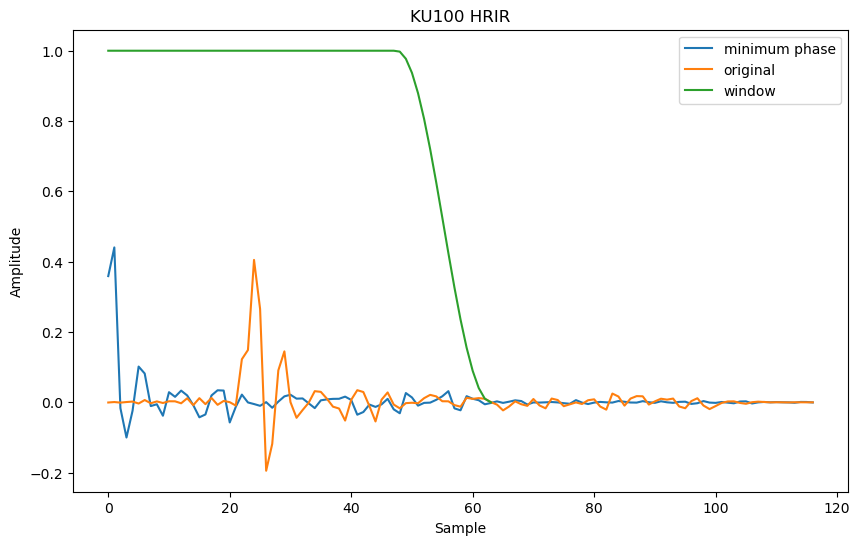

In [30]:
min_hrir_signal = get_minimum_phase_hrir(resampled_hrir)
env = get_envelope(min_hrir_signal)

idx = 0

half_hann_window = np.ones(64)
half_hann_window[-16:] = np.hanning(32)[-16:]

cum = np.cumsum(env)
cum /= cum[-1]
# find the index of the 1% and 99% points
idx_1 = np.argmin(np.abs(cum - 0.01))
idx_99 = np.argmin(np.abs(cum - 0.99))
print(idx_1, idx_99, env.shape)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(min_hrir_signal[idx, 0, :], label='minimum phase')
ax.plot(resampled_hrir[idx, 0, :], label='original')
ax.plot(half_hann_window, label='window')
ax.set_xlabel('Sample')
ax.set_ylabel('Amplitude')
ax.set_title('KU100 HRIR')
ax.legend()
plt.show()

## Get ITDs

In [31]:
itds = spa.process.itds_from_hrirs(spa_hrir)
np.savetxt(os.path.join(hrir_dir, 'itds.txt'), itds, fmt='%f')

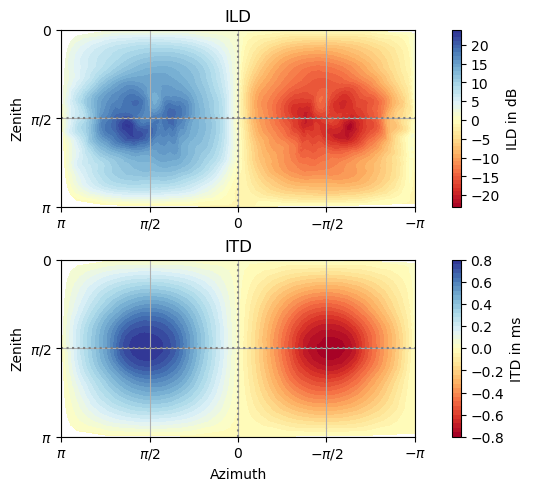

In [32]:
spa.plot.hrirs_ild_itd(spa_hrir)

## Save HRIRs to wav Files

In [33]:
# print(hrir_signal.reshape(-1, hrir_signal.shape[-1]).T.shape)
# sf.write(hrir_wave_path, hrir_signal.reshape(-1, hrir_signal.shape[-1]).T, sr)

os.makedirs(hrir_dir, exist_ok=True)
for i in range(hrir_xyz.shape[0]):
    hrir_wave_path = os.path.join(hrir_dir, f'{i}.wav')
    sf.write(hrir_wave_path, resampled_hrir[i].T, target_sr)

    min_hrir_wave_path = os.path.join(hrir_dir, f'{i}_min.wav')
    sf.write(min_hrir_wave_path, min_hrir_signal[i].T, target_sr)

# wavfile.write(hrir_wave_path, sr, hrir_signal.reshape(-1, hrir_signal.shape[-1]).T)

# np.savetxt(os.path.join(hrir_dir, hrir_pos_path), hrir_xyz, fmt='%.6f')

## Triangularisation

In [34]:
hull = ConvexHull(hrir_xyz)

print("Number of simplices: %d" % hull.nsimplex)

Number of simplices: 5400


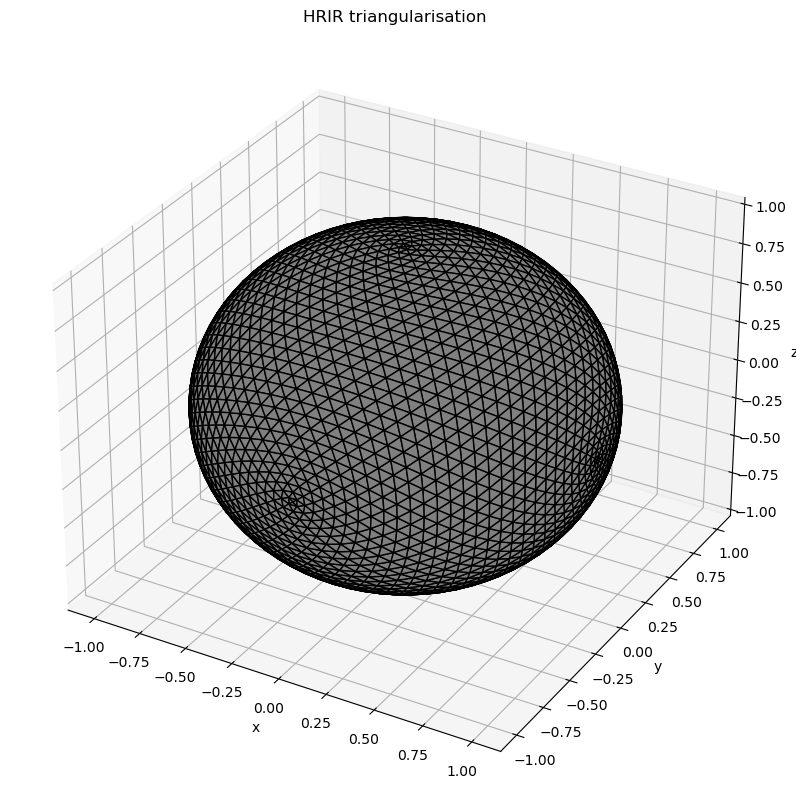

In [35]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# ax.scatter(hrir_xyz[:, 0], hrir_xyz[:, 1], hrir_xyz[:, 2], c='r', marker='o')
# for simplex in hull.simplices:
    # ax.plot(hrir_xyz[simplex, 0], hrir_xyz[simplex, 1], hrir_xyz[simplex, 2], 'k-', alpha=0.5)

X, Y, Z = hrir_xyz[:, 0], hrir_xyz[:, 1], hrir_xyz[:, 2]
ax.plot_trisurf(X, Y, hull.simplices, Z, color='grey', shade=False, 
                       linewidth=1, antialiased=True, edgecolor = 'black')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z') 
ax.set_title('HRIR triangularisation')
plt.show()

In [36]:
included_simplices = [[] for _ in range(hull.points.shape[0])]

for i, simplex in enumerate(hull.simplices):
    for j in simplex:
        included_simplices[j].append(i)

print(included_simplices)
print(max([len(s) for s in included_simplices]), min([len(s) for s in included_simplices]))

[[1080, 3074, 3101, 3104], [2216, 2217, 3073, 3075, 3463, 3467], [3080, 3466, 3468, 4126, 5296, 5299], [4035, 4036, 4129, 5111, 5297, 5298], [4683, 4684, 4685, 4686, 4687, 4688], [4031, 4032, 4033, 4034, 4056, 4057], [4028, 4029, 4030, 5108, 5284, 5287], [2289, 3505, 4409, 4680, 5285, 5286], [4929, 4930, 4931, 4932, 4933, 4934], [2284, 2285, 3501, 3502, 3908, 3910], [1582, 1583, 2797, 2798, 3907, 3909], [608, 1579, 1584, 1585, 4636, 4637], [2799, 2800, 2801, 4638, 5084, 5085], [106, 107, 604, 605, 832, 833], [14, 105, 589, 591, 835, 836], [588, 590, 2702, 2704], [1490, 1491, 1492, 2705, 3843, 3844], [2747, 2748, 2749, 2750, 2751, 2752], [559, 1493, 1530, 1531, 3899, 3903], [1532, 1533, 1534, 2763, 3900, 3904], [575, 576, 577, 578, 1535, 1536], [94, 95, 96, 570, 580, 582], [525, 581, 1551, 1552, 1557, 1558], [524, 534, 535, 1738, 3981, 3984], [715, 716, 1725, 2926, 3980, 3985], [542, 1508, 1724, 1726, 2725, 2729], [548, 549, 2724, 2728, 2733, 2734], [732, 733, 740, 741, 2730, 2735], [14

## Save Coordinates and Neighbour Simplices as TEXT File

In [37]:
hrir_xyz_list = hrir_xyz.tolist()
hrir_info = [hrir_xyz_list[i] + included_simplices[i] for i in range(len(hrir_xyz_list))]
print(hrir_info)

# write list of list to file
with open(os.path.join(hrir_dir, 'info.txt'), 'w') as f:
    for item in hrir_info:
        f.write(" ".join(str(x) for x in item) + "\n")

[[0.0, 0.0, 1.0, 1080, 3074, 3101, 3104], [0.06123554989894763, 0.0, 0.9981233427931507, 2216, 2217, 3073, 3075, 3463, 3467], [0.1533070348312394, 0.0, 0.9881786038319456, 3080, 3466, 3468, 4126, 5296, 5299], [0.25639026052442054, 0.0, 0.9665733465744955, 4035, 4036, 4129, 5111, 5297, 5298], [0.3629346991663361, 0.0, 0.9318145760509658, 4683, 4684, 4685, 4686, 4687, 4688], [0.46839499689875375, 0.0, 0.8835191717672098, 4031, 4032, 4033, 4034, 4056, 4057], [0.5694479240657953, 0.0, 0.8220274093831399, 4028, 4029, 4030, 5108, 5284, 5287], [0.6634465430993957, 0.0, 0.748223686105607, 2289, 3505, 4409, 4680, 5285, 5286], [0.748223686105607, 0.0, 0.6634465430993957, 4929, 4930, 4931, 4932, 4933, 4934], [0.8220274093831399, 0.0, 0.5694479240657953, 2284, 2285, 3501, 3502, 3908, 3910], [0.8835191717672098, 0.0, 0.4683949968987538, 1582, 1583, 2797, 2798, 3907, 3909], [0.9318145760509658, 0.0, 0.3629346991663361, 608, 1579, 1584, 1585, 4636, 4637], [0.9665733465744955, 0.0, 0.25639026052442077

## Save Simplices Indexes and Inverse Matrices Weights

In [38]:
simplex_points = hull.points[hull.simplices]
inv = np.linalg.inv(simplex_points)
inv = np.swapaxes(inv, 1, 2).reshape(-1, 9)
print(inv)

simplex_info = [hull.simplices[i].tolist() + inv[i].tolist() for i in range(hull.simplices.shape[0])]

# write list of list to file
with open(os.path.join(hrir_dir, 'simplices.txt'), 'w') as f:
    for item in simplex_info:
        f.write(" ".join(str(x) for x in item) + "\n")


[[ -4.74957135   6.82402111  12.27261255 ...  -3.99688368   7.53919958
  -11.89675062]
 [  1.55704425  -9.77025205 -12.89555418 ...  -4.83983023  18.24582139
   -1.04973017]
 [-15.88521526  -2.95464085   5.39179267 ...   6.10116124  14.32617981
   -4.72953151]
 ...
 [ -4.9719399   -5.53909375 -14.75615384 ...  -9.96372663  -0.80767447
   10.91921505]
 [  6.63542631   3.86678982  14.52364915 ... -16.5420691   -5.61474336
   -3.07681529]
 [ -9.47569565  -1.60168057  11.52698978 ...  -6.10116124  -4.72953151
  -14.32617981]]
